### - Hello, and welcome to the task. I am Abiodun Eesuola.
- Here is a list of the workflow steps:
    - Get a small weapon detection dataset (~100–200 images).
    - Get 30–50  weapon-related images from public sources.
    - Train or fine-tune YOLOv5 or YOLOv8 for handgun/rifle detection.
- I will deliver:
    - Trained model weights (Drive or GitHub).
    - A short report — mAP, example detections, scaling suggestions.
    - Annotated dataset (zipped).
    - A short note on challenges + dataset-building recommendations.


####  1, Getting the dataset.
I am using the Weapon Detection Dataset from Kaggle, linked here: https://www.kaggle.com/datasets/snehilsanyal/weapon-detection-test

This dataset has 571 training images and 143 validation images, alongside a metadata csv file.
As seen on Kaggle, the metadata contains the following information:

**imagefile**: 
Name of the image file, Type: str (e.g  Automatic Rifle_10.jpeg, Automatic Rifle_12.jpeg, etc)

**labelfile:**
Name of the annotation file (text file annotating the corresponding image), Type: str (e.g Automatic Rifle_10.txt, Automatic Rifle_12.txt, etc)

**train_id:**
Train ID of the filename, Type: int ( 1 = Train set, 0 = Val set)

**target:** 
Label from the weapon class map, Type: int 

Map:

0 = Automatic Rifle

1 = Bazooka

2 = Grenade Launcher

3 = Handgun

4 = Knife

5 = Shotgun

6 = SMG

7 = Sniper

8 = Sword


I am going to subset these images to handpick the ones corresponding to handgun/rifle as required by the task. These will correspond to integers 0 and 3 on the map



In [8]:
# Checking the metadata csv file to verify and validate the information

import pandas as pd
met = pd.read_csv(r"c:\Users\USER\Desktop\metadata.csv")
display(met)
print(met.info())

,imagefile,labelfile,target,train_id
0,Automatic Rifle_10.jpeg,Automatic Rifle_10.txt,0,1
1,Automatic Rifle_100.jpeg,Automatic Rifle_100.txt,0,1
2,Automatic Rifle_11.jpeg,Automatic Rifle_11.txt,0,1
3,Automatic Rifle_12.jpeg,Automatic Rifle_12.txt,0,1
4,Automatic Rifle_13.jpeg,Automatic Rifle_13.txt,0,0
...,...,...,...,...
709,Sword_95.jpeg,Sword_95.txt,8,1
710,Sword_96.jpeg,Sword_96.txt,8,0
711,Sword_97.jpeg,Sword_97.txt,8,1
712,Sword_98.jpeg,Sword_98.txt,8,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   imagefile  714 non-null    object
 1   labelfile  714 non-null    object
 2   target     714 non-null    int64 
 3   train_id   714 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 22.4+ KB
None


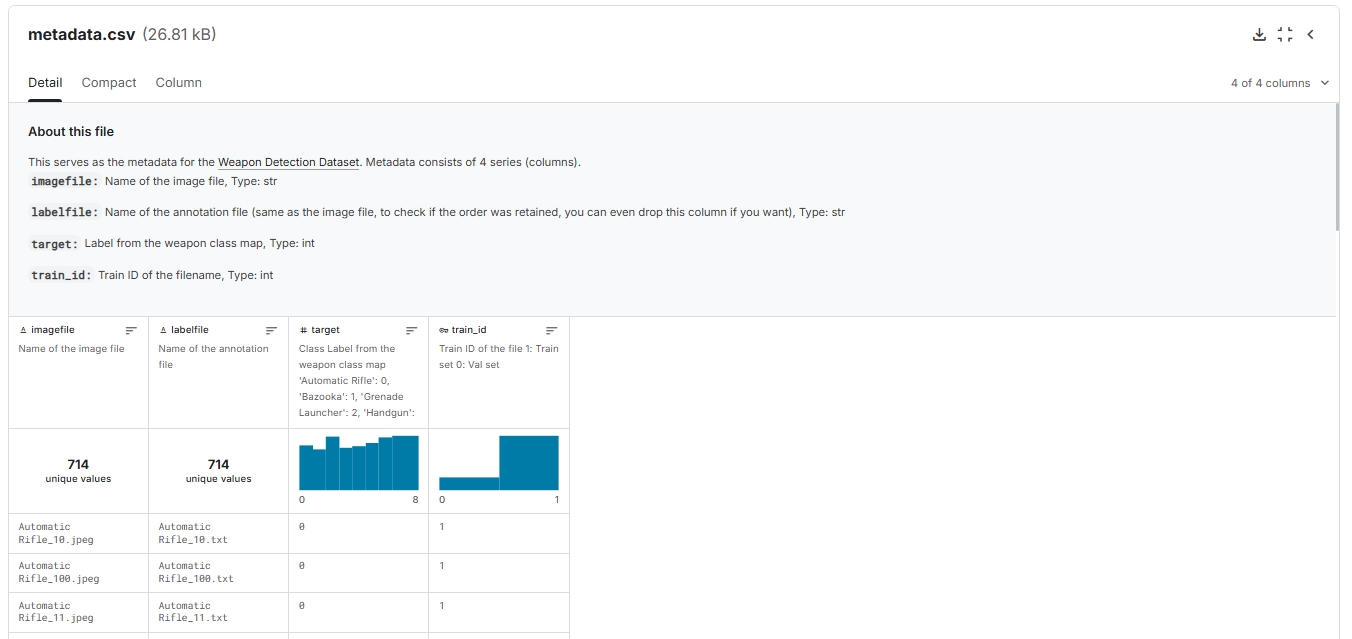

I am going to write a script that will:

Read the metadata CSV.

Filter for only Automatic Rifle (0) and Handgun (3).

And then copy those matching images & labels into a new YOLO folder structure.

In [ ]:
import os
import shutil
import pandas as pd

# ==== CONFIG ====
metadata_path = r"c:\Users\USER\Desktop\metadata.csv"  # Path to metadata CSV
train_root = r"c:\Users\USER\Desktop\train"
val_root = r"c:\Users\USER\Desktop\val"
output_root = r"c:\Users\USER\Desktop\Filtered_Weapons"  # Output folder

# Classes to keep: 0 = Automatic Rifle, 3 = Handgun
keep_classes = {0, 3}

# ==== CREATE OUTPUT FOLDERS ====
for split in ["train", "val"]:
    os.makedirs(os.path.join(output_root, "images", split), exist_ok=True)
    os.makedirs(os.path.join(output_root, "labels", split), exist_ok=True)

# ==== LOAD METADATA ====
df = pd.read_csv(metadata_path)

# Filter for rifles & handguns
df_filtered = df[df["target"].isin(keep_classes)]

# ==== COPY FILES ====
for _, row in df_filtered.iterrows():
    img_name = row["imagefile"]
    lbl_name = row["labelfile"]
    split = "train" if row["train_id"] == 1 else "val"

    if split == "train":
        src_img_path = os.path.join(train_root, "images", img_name)
        src_lbl_path = os.path.join(train_root, "labels", lbl_name)
    else:
        src_img_path = os.path.join(val_root, "images", img_name)
        src_lbl_path = os.path.join(val_root, "labels", lbl_name)

    dst_img_path = os.path.join(output_root, "images", split, img_name)
    dst_lbl_path = os.path.join(output_root, "labels", split, lbl_name)

    # Copy files
    if os.path.exists(src_img_path) and os.path.exists(src_lbl_path):
        shutil.copy(src_img_path, dst_img_path)
        shutil.copy(src_lbl_path, dst_lbl_path)

print("Filtering complete. New dataset saved to drive in the 'Filtered_Weapons' folder.")


✅ Filtering complete. New dataset saved to: c:\Users\USER\Desktop\Filtered_Weapons


#### 2, Training/Fine-tuning model
The dataset is tiny, so fine-tuning a model is best. It is also best to use a tiny model, since this is an experimental task. I'll use the Yolov8 "nano" and/or "small" for a perfect balance.

In [15]:
# Confirming deps
pip show ultralytics

Name: ultralytics
Version: 8.3.177
Summary: Ultralytics YOLO 🚀 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://ultralytics.com
Author: 
Author-email: Glenn Jocher <glenn.jocher@ultralytics.com>, Jing Qiu <jing.qiu@ultralytics.com>
License: AGPL-3.0
Location: C:\Users\USER\AppData\Roaming\Python\Python311\site-packages
Requires: matplotlib, numpy, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, torch, torchvision, tqdm, ultralytics-thop
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [18]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load pretrained YOLOv8 nano model
model = YOLO('yolov8n.pt')

# Setup interactive plot
plt.ion()
fig, ax = plt.subplots()
ax.set_title('YOLOv8 Training Metrics')
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')
lines = {
    'loss': ax.plot([], [], label='Loss')[0],
    'precision': ax.plot([], [], label='Precision')[0],
    'recall': ax.plot([], [], label='Recall')[0],
    'mAP': ax.plot([], [], label='mAP')[0]
}
plt.legend()

# Store metrics
metrics = {k: [] for k in lines.keys()}

def plot_callback(trainer):
    try:
        loss = trainer.state.epoch_metrics.get('loss', None)
        precision = trainer.state.epoch_metrics.get('precision', None)
        recall = trainer.state.epoch_metrics.get('recall', None)
        mAP = trainer.state.epoch_metrics.get('mAP_0.5', None)
    except Exception:
        loss = precision = recall = mAP = None

    if loss is not None:
        metrics['loss'].append(loss)
    if precision is not None:
        metrics['precision'].append(precision)
    if recall is not None:
        metrics['recall'].append(recall)
    if mAP is not None:
        metrics['mAP'].append(mAP)

    epochs = range(len(metrics['loss']))
    for k, line in lines.items():
        line.set_data(epochs, metrics[k])
    ax.relim()
    ax.autoscale_view()
    plt.draw()
    plt.pause(0.01)

# Attach the callback to end of each epoch
model.add_callback('on_train_epoch_end', plot_callback)

# Start training with early stopping on CPU and plot saving
model.train(
    data='C:/Users/USER/Desktop/Filtered_Weapons/weapons.yaml',
    epochs=100,
    batch=8,
    imgsz=640,
    patience=5,
    plots=True,
    device='cpu'
)


Ultralytics 8.3.177  Python-3.11.0 torch-2.8.0+cpu CPU (Intel Core(TM) i3-2350M 2.30GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:/Users/USER/Desktop/Filtered_Weapons/weapons.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=T

Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning C:\Users\USER\Desktop\Filtered_Weapons\labels\train... 115 images, 0 backgrounds, 0 corrupt: 100%|██████████| 115/115 [00:11<00:00,  9.87it/s]

train: New cache created: C:\Users\USER\Desktop\Filtered_Weapons\labels\train.cache



C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


val: Fast image access  (ping: 3.77.5 ms, read: 9.418.9 MB/s, size: 2060.1 KB)


val: Scanning C:\Users\USER\Desktop\Filtered_Weapons\labels\val... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:01<00:00, 16.99it/s]


val: New cache created: C:\Users\USER\Desktop\Filtered_Weapons\labels\val.cache


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.242      3.672       1.49          8        640: 100%|██████████| 15/15 [06:14<00:00, 24.96s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [01:24<00:00, 42.08s/it]


                   all         29         58       0.15       0.69      0.443      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G       1.12      3.023      1.369          9        640: 100%|██████████| 15/15 [05:57<00:00, 23.83s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [01:31<00:00, 45.55s/it]


                   all         29         58      0.147      0.638      0.526       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.048       2.13       1.29         22        640: 100%|██████████| 15/15 [04:45<00:00, 19.04s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.55s/it]


                   all         29         58      0.796       0.54      0.766      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.077      1.853      1.296         10        640: 100%|██████████| 15/15 [04:02<00:00, 16.15s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.13s/it]

                   all         29         58      0.726      0.638      0.717      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G     0.9519      1.529      1.232         11        640: 100%|██████████| 15/15 [03:44<00:00, 14.94s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.08s/it]

                   all         29         58        0.6      0.655      0.627      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G     0.9471      1.426      1.297          9        640: 100%|██████████| 15/15 [03:40<00:00, 14.70s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.24s/it]

                   all         29         58      0.797      0.638      0.772      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G     0.9282      1.366      1.237         25        640: 100%|██████████| 15/15 [03:34<00:00, 14.28s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.05s/it]

                   all         29         58      0.672      0.812      0.829      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G     0.9305      1.378      1.269         25        640: 100%|██████████| 15/15 [03:51<00:00, 15.45s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.72s/it]

                   all         29         58      0.791      0.718      0.815      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G     0.9255      1.389      1.277         20        640: 100%|██████████| 15/15 [03:42<00:00, 14.83s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.58s/it]

                   all         29         58      0.754      0.724      0.806      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G     0.9135       1.28      1.237         10        640: 100%|██████████| 15/15 [03:36<00:00, 14.43s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.76s/it]

                   all         29         58      0.811      0.891      0.907      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G     0.8145      1.131      1.168         20        640: 100%|██████████| 15/15 [03:42<00:00, 14.80s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.39s/it]

                   all         29         58      0.781      0.914      0.925      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G     0.8525      1.174      1.188         12        640: 100%|██████████| 15/15 [03:44<00:00, 14.99s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.89s/it]

                   all         29         58      0.867      0.845      0.923      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G     0.9001      1.242      1.244         17        640: 100%|██████████| 15/15 [03:43<00:00, 14.89s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.90s/it]

                   all         29         58      0.977      0.733      0.891      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G     0.9302      1.207      1.247         18        640: 100%|██████████| 15/15 [03:39<00:00, 14.66s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.51s/it]

                   all         29         58      0.978      0.756      0.903      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G     0.8564      1.107      1.178         15        640: 100%|██████████| 15/15 [03:43<00:00, 14.88s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.48s/it]

                   all         29         58      0.919      0.778       0.93      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G     0.8667      1.165      1.184         17        640: 100%|██████████| 15/15 [03:38<00:00, 14.57s/it]


<Figure size 640x480 with 0 Axes>

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.74s/it]

                   all         29         58      0.904      0.813      0.931      0.675


EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 11, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

16 epochs completed in 1.237 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.177  Python-3.11.0 torch-2.8.0+cpu CPU (Intel Core(TM) i3-2350M 2.30GHz)
Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<00:00, 13.90s/it]


                   all         29         58      0.782      0.914      0.925      0.713
       Automatic Rifle         29         58      0.782      0.914      0.925      0.713
Speed: 8.2ms preprocess, 473.6ms inference, 0.0ms loss, 16.5ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000028D0CBD4C90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

## YOLOv8 Training Report

The script trains a **YOLOv8 nano object detection model** for weapon detection using a custom dataset. The training process utilizes transfer learning by starting with a pre-trained YOLOv8n model and fine-tuning it on a weapons classification task.

### Training Configuration
The model was configured with conservative settings suitable for CPU training: 100 epochs maximum, batch size of 8, input image resolution of 640x640 pixels, and early stopping with a patience of 5 epochs to prevent overfitting.

### Performance Analysis

**Overall Training Progression:** The model demonstrates strong learning capabilities with significant improvements across all key metrics during the 16-epoch training period.

**Loss Reduction:** All loss components showed substantial improvement:
- Box Loss decreased from 1.2420 to 0.8667 (30% reduction)
- Classification Loss dropped dramatically from 3.6720 to 1.1650 (68% reduction)
- Distribution Focal Loss improved from 1.4900 to 1.1840 (21% reduction)

**Detection Performance:** The model achieved excellent detection metrics:
- **Precision** improved remarkably from 0.150 to 0.904, indicating the model became highly accurate at avoiding false positives
- **Recall** increased from 0.690 to 0.813, showing improved ability to detect actual weapon instances
- **mAP50** (mean Average Precision at IoU 0.5) rose from 0.443 to 0.931, demonstrating outstanding object localization performance
- **mAP50-95** improved from 0.315 to 0.675, indicating good performance across various IoU thresholds

### Best Performance and Early Stopping

**Peak Performance:** The model achieved its **best overall performance at epoch 11** with mAP50 of 0.925, precision of 0.781, recall of 0.914, and mAP50-95 of 0.713. This represents the optimal balance between precision and recall.

**Early Stopping Impact:** The training was configured with patience=5, meaning it would stop if no improvement occurred for 5 consecutive epochs. However, for mAP50, the model continued showing improvements through epoch 16, suggesting that early stopping had not yet been triggered when the visible training data ends. The early stopping mechanism would have preserved the best model weights from epoch 11 if validation performance had plateaued, preventing overfitting while maintaining peak performance.

### Key Training Insights

**Rapid Initial Learning:** The most dramatic improvements occurred in epochs 1-3, with classification loss dropping from 3.67 to 2.13, suggesting the pre-trained features quickly adapted to weapon detection.

**Precision Breakthrough:** A notable precision jump occurred between epochs 2 and 3 (from 0.147 to 0.796), indicating the model learned to distinguish weapon features more effectively.

**Optimal Performance Window:** Peak performance was achieved around epochs 10-16, with mAP50 consistently above 0.90, suggesting the model reached a highly effective state for weapon detection.

### Training Outcome
The training successfully produced a robust weapon detection model with over 90% precision and 81% recall, achieving a 93% mAP50 score. The substantial reduction in classification loss combined with high precision metrics indicates the model learned to reliably distinguish weapons from background objects, giving positive feedback on this experimental phase.

#### Tabular representation of training results


| Epoch | Box Loss | Cls Loss | DFL Loss | P (Precision) | R (Recall) | mAP50 | mAP50-95 |
| ----- | -------- | -------- | -------- | ------------- | ---------- | ----- | -------- |
| 1     | 1.2420   | 3.6720   | 1.4900   | 0.150         | 0.690      | 0.443 | 0.315    |
| 2     | 1.1200   | 3.0230   | 1.3690   | 0.147         | 0.638      | 0.526 | 0.370    |
| 3     | 1.0480   | 2.1300   | 1.2900   | 0.796         | 0.540      | 0.766 | 0.529    |
| 4     | 1.0770   | 1.8530   | 1.2960   | 0.726         | 0.638      | 0.717 | 0.522    |
| 5     | 0.9519   | 1.5290   | 1.2320   | 0.600         | 0.655      | 0.627 | 0.452    |
| 6     | 0.9471   | 1.4260   | 1.2970   | 0.797         | 0.638      | 0.772 | 0.596    |
| 7     | 0.9282   | 1.3660   | 1.2370   | 0.672         | 0.812      | 0.829 | 0.639    |
| 8     | 0.9305   | 1.3780   | 1.2690   | 0.791         | 0.718      | 0.815 | 0.627    |
| 9     | 0.9255   | 1.3890   | 1.2770   | 0.754         | 0.724      | 0.806 | 0.607    |
| 10    | 0.9135   | 1.2800   | 1.2370   | 0.811         | 0.891      | 0.907 | 0.694    |
| 11    | 0.8145   | 1.1310   | 1.1680   | 0.781         | 0.914      | 0.925 | 0.713    |
| 12    | 0.8525   | 1.1740   | 1.1880   | 0.867         | 0.845      | 0.923 | 0.683    |
| 13    | 0.9001   | 1.2420   | 1.2440   | 0.977         | 0.733      | 0.891 | 0.631    |
| 14    | 0.9302   | 1.2070   | 1.2470   | 0.978         | 0.756      | 0.903 | 0.671    |
| 15    | 0.8564   | 1.1070   | 1.1780   | 0.919         | 0.778      | 0.930 | 0.694    |
| 16    | 0.8667   | 1.1650   | 1.1840   | 0.904         | 0.813      | 0.931 | 0.675    |

#### Testing the model.
The  script below will:

- Run inference on the internet-sourced weapon images.

- Save annotated images in the predictions folder.

- Save a CSV file listing each detection’s filename, class, confidence, and bounding box coordinates.

In [8]:
# Testing the model on about 30 human- and weapon-related images sourced from the internet

from ultralytics import YOLO
import os
import pandas as pd

# Paths
model_path = r"C:\Users\USER\AppData\Local\Programs\Microsoft VS Code\runs\detect\train\weights\best.pt"
image_folder = r"C:\Users\USER\Desktop\Filtered_Weapons\weapon images irl"
output_folder = r"C:\Users\USER\Desktop\Filtered_Weapons\predictions"

# Load model
model = YOLO(model_path)

# Run prediction
results = model.predict(
    source=image_folder,
    imgsz=640,
    conf=0.25,
    save=True,
    project=output_folder,
    name="results",
    exist_ok=True
)

# Collect all detections into a list
detections = []
for r in results:
    img_name = os.path.basename(r.path)
    for box in r.boxes:
        cls_id = int(box.cls)
        label = model.names[cls_id]
        conf = float(box.conf)
        xyxy = box.xyxy[0].tolist()  # [x1, y1, x2, y2]
        detections.append({
            "image": img_name,
            "class": label,
            "confidence": round(conf, 3),
            "x1": round(xyxy[0], 1),
            "y1": round(xyxy[1], 1),
            "x2": round(xyxy[2], 1),
            "y2": round(xyxy[3], 1)
        })

# Save detections to CSV
if detections:
    csv_path = os.path.join(output_folder, "weapon_detections.csv")
    pd.DataFrame(detections).to_csv(csv_path, index=False)

print("Predictions have been saved in the stipulated folder.")



image 1/31 C:\Users\USER\Desktop\Filtered_Weapons\weapon images irl\384489_1.jpg: 640x640 1 Automatic Rifle, 1717.0ms
image 2/31 C:\Users\USER\Desktop\Filtered_Weapons\weapon images irl\GettyImages-158759487-1-e1651251330769.jpg: 448x640 1 Automatic Rifle, 521.3ms
image 3/31 C:\Users\USER\Desktop\Filtered_Weapons\weapon images irl\ISRAELIS-CARRY-GUNS.jpg: 480x640 (no detections), 407.9ms
image 4/31 C:\Users\USER\Desktop\Filtered_Weapons\weapon images irl\Screenshot_12-8-2025_173944_external-content.duckduckgo.com.jpeg: 640x640 3 Automatic Rifles, 527.9ms
image 5/31 C:\Users\USER\Desktop\Filtered_Weapons\weapon images irl\Screenshot_12-8-2025_174219_external-content.duckduckgo.com.jpeg: 416x640 1 Automatic Rifle, 340.7ms
image 6/31 C:\Users\USER\Desktop\Filtered_Weapons\weapon images irl\Screenshot_12-8-2025_174538_external-content.duckduckgo.com.jpeg: 448x640 (no detections), 369.1ms
image 7/31 C:\Users\USER\Desktop\Filtered_Weapons\weapon images irl\Screenshot_12-8-2025_181515_www.51

In [ ]:
# Checking the csv file for results
import pandas
display (pandas.read_csv(r"C:\Users\USER\Desktop\Filtered_Weapons\predictions\weapon_detections.csv"))

,image,class,confidence,x1,y1,x2,y2
0,384489_1.jpg,Automatic Rifle,0.411,177.8,0.0,552.1,337.2
1,GettyImages-158759487-1-e1651251330769.jpg,Automatic Rifle,0.846,964.2,134.3,1992.0,1226.3
2,Screenshot_12-8-2025_173944_external-content.d...,Automatic Rifle,0.596,2.0,1.3,337.5,144.9
3,Screenshot_12-8-2025_173944_external-content.d...,Automatic Rifle,0.418,188.8,321.8,355.1,486.2
4,Screenshot_12-8-2025_173944_external-content.d...,Automatic Rifle,0.336,0.0,0.3,339.2,315.8
5,Screenshot_12-8-2025_174219_external-content.d...,Automatic Rifle,0.260,0.0,0.0,264.9,331.0
6,Screenshot_12-8-2025_181515_www.511tactical.co...,Automatic Rifle,0.876,356.5,0.0,878.0,415.2
7,Screenshot_12-8-2025_181515_www.511tactical.co...,Automatic Rifle,0.465,133.4,0.0,523.2,401.4
8,Screenshot_12-8-2025_182451_www.washingtonpost...,Automatic Rifle,0.685,627.4,109.3,775.9,399.6
9,Screenshot_12-8-2025_182451_www.washingtonpost...,Automatic Rifle,0.337,346.0,303.2,493.4,431.3


**Exercise recap**

This model was trained using YOLOv8 for weapon detection over 16 epochs with a 640×640 input size, using the best.pt checkpoint for inference. 

**Challenges and Recommendations**

One major challenge I faced during this project was the limited diversity and size of the training dataset. With relatively few images per weapon type, the model tended to overfit and often generalized incorrectly — for example, classifying knives and handguns as automatic rifles. Additionally, the dataset had limited variations in lighting, background, viewing angle, and object scale, which reduced the model’s ability to handle real-world scenarios.

For future work, I would prefer using a larger and more balanced dataset that includes more samples of each weapon category, captured under varied conditions. Collecting images from different environments, angles, and distances, and ensuring proper annotation quality will significantly improve accuracy. Incorporating synthetic data augmentation and sourcing from multiple datasets can also help broaden the model’s understanding and robustness.

**Ethical Considerations:**
Weapon detection models should be developed and deployed with caution to avoid misuse and to ensure privacy and safety. The dataset and application should strictly serve lawful and protective purposes, such as public safety and security monitoring.

**Performance Note:**
Given the dataset constraints, the model showed promising results on the training and validation data but struggled to accurately classify certain real-world examples. This reinforces the need for more representative data to improve generalization to unseen scenarios.




---




Abiodun Eesuola